<a href="https://colab.research.google.com/github/taunoe/jupyter-notebooks/blob/main/Objektiklasside_ennustamine_CIFAR10_andmestiku_p%C3%B5hjal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objektiklasside ennustamine CIFAR10 andmestiku põhjalURL
*Praktilise näite autor: Ardi Tampuu*

##Objektituvastus

Selles praktikumis me rakendame tehisnärvivõrke **objektituvastuse ülesandele.**

Nagu loengus mainiti, on tehisnärvivõrgud võimelised õppima näidete põhjal (**juhendatud õpe**). Õppimine seisneb selles, et optimiseerimisalgoritm muudab närvivõrgu neuronite vahelisi ühendusi (ühendustugevusi ehk kaale) nii, et võrgu väljundid vastaks võimalikult täpselt oodatavatele vastustele ehk märgendile.

Käesolevas praktilises töös näeme me, kuidas saab tehisnärvivõrke kasutades piltidel/fotodel olevat info põhjal otsustada näiteks, kes või mis on pildil.

Käesolevas vihikus:
- Tutvume CIFAR10 andmestikuga, mis sisaldab pilte ja märgendeid. Pildid kuuluvad 10 erinevasse klassi.
- Vaatame **täissidusatel tehisnärvivõrkudel** baseeruvat mudelit ja seda, kui hästi see suudab piltide klasse ennustada
- Vaatame **konvolutsioonilistel tehisnärvivõrkudel** baseeruvat mudelit ja seda, kui hästi see suudab piltide klasse ennustada
- Analüüsime mudelite tehtud vigu
- Uurime, mis piirides mudel hästi töötab, kas on mingit tüüpi sisendid, mis mudeli segadusse ajavad

##Tarkvara

Kuna rakendame selles praktikumis tehisnärvivõrke, mis koosnevad tuhandetest neuronitest ja mis teevad iga sisendpildi puhul miljoneid arvutusi, siis:

1) Kasutame nendega töötamiseks spetsiaalseid teeke (koodiraamatukogusid) nimedega "tensorflow" ja "keras". 

2) **Me ei treeni siin vihikus mudeleid, vaid kasutame juba treenitud mudeleid.** Treenimine võtaks liialt kaua aega. Need treenitud mudelid on selle praktilise vihiku autor treeninud oma tööarvutis kasutades CIFAR10 andmestikku. Sõltuvalt mudelist võttis see aega mõned minutid kuni mõned tunnid.

## Teekide installimine


In [1]:
#!pip install --upgrade grpcio==1.24.3
!pip install --upgrade tensorflow -q
!pip install --upgrade keras -q

**Järgnevas koodikastis** loeme sisse vajalikud teegid ja kontrollime, et nende versioonid on meile sobivad.


In [4]:
import keras # tehisnärvivõrkude teek
import tensorflow
import numpy as np
print(keras.__version__)
print(tensorflow.__version__)

#assert(keras.__version__ == "2.3.1")
assert(tensorflow.__version__>= "2.0.0")

#from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

2.4.3
2.4.1


## 1.  Andmestik

Näitlikustame tehisnärvivõrkude objektide tuvastamise võimekust CIFAR10 andmestikul. See andmestik koosneb 32x32 piksli suurustest värvilistest piltidest (seega on iga pilt 32x32x3 suurune kolmemõõtmeline arvudemassiv). Iga pildi kohta on olemas ka märgend, mis ütleb, milline objekt on pildil. Pildid kuuluvad 10 erinevasse klassi: 'lennuk', 'auto', 'lind', 'kass', 'hirv', 'koer', 'konn', 'hobune', 'laev', 'veoauto'.

Kasutame siin CIFAR10 andmestikku, sest: 
- kasutasime seda ka otsustusmetsa näites
- pildid on piisavalt väikesed, et arvutused ei võtaks kaua aega. Kasutades näiteks ImageNet andmestikku, kus pildid on suurusega 224x224, on igas pildis ligi 50 korda rohkem piksleid. See tähendab, et igal pildi jaoks ennustuse tegemine võtaks palju rohkem aega ja käesolevas vihikus oleva koodi läbi jooksutamine muutuks ajakulukaks.


<br>

**Järgnev koodijupp**
- Laeb CIFAR10 andmestiku alla ja visualiseerib igast objektitüübist ühe pildi. (**Allalaadimine võib võtta mõne minuti.** Andmestik laetakse mitte teie arvutisse, vaid Google'i serverisse, kus asub ka käesolev virtuaalne vihik)
- Kirjutab välja andmestikus olevate piltide mõõtmed ja visualiseerib igast klassist ühe näite.


Treening-andmestiku suurus on: (piltide arv, pildi kõrgus, pildi laius, värvikanalite arv):  (50000, 32, 32, 3)

 Näited: üks pilt igast klassist 



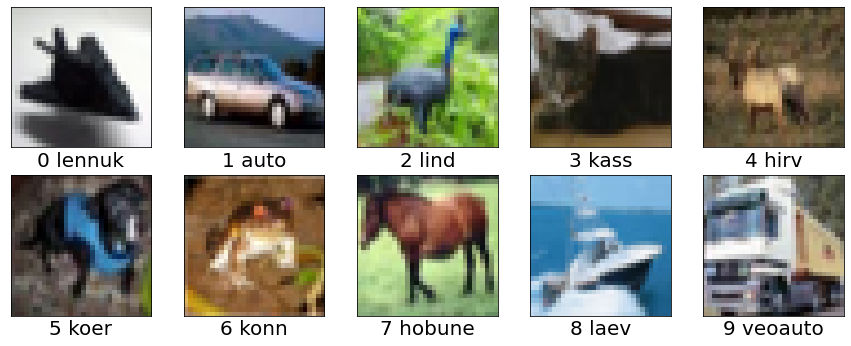

Valideerimisandmestiku suurus on: (piltide arv, pildi kõrgus, pildi laius, värvikanalite arv):  (10000, 32, 32, 3)


In [6]:
import numpy as np # arvutuslik Python
import matplotlib.pyplot as plt # graafikute, visualisatsioonide teek

# Cifar 10 andmestik on Kerase teegist lihtsasti kättesaadav
(train_img, train_label), (test_img, test_label) = keras.datasets.cifar10.load_data()
class_names = ['lennuk', 'auto', 'lind', 'kass', 'hirv', 'koer', 'konn', 'hobune', 'laev', 'veoauto']
#train_label=train_label.flatten()

# Klassinumbrid tuleb muuta ühe-mitmest kujule (ingl one-hot) (meie mudel eeldab nii)
oh_train_label = keras.utils.to_categorical(train_label, 10)
oh_test_label = keras.utils.to_categorical(test_label, 10)

#piltidele tehakse teatav eeltöötlus. 
#Piksliväärtused viiakse vahemikust [0,255] vahemikku [0,1]
train_img = train_img.astype('float32') /255
test_img = test_img.astype('float32') /255

#ja piltide piksliväärtustest lahutatakse "keskmine pilt"
x_train_mean = np.mean(train_img, axis=0)
train_img -= x_train_mean
test_img -= x_train_mean

print("Treening-andmestiku suurus on: (piltide arv, pildi kõrgus, pildi laius, värvikanalite arv): ", train_img.shape)
print("\n Näited: üks pilt igast klassist \n")
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    first_idx = np.argwhere(train_label==i)[0][0]
    plt.imshow(train_img[first_idx]+x_train_mean, cmap=plt.cm.binary)
    plt.xlabel(str(i)+" "+class_names[i],fontsize=20)
plt.show()

print("Valideerimisandmestiku suurus on: (piltide arv, pildi kõrgus, pildi laius, värvikanalite arv): ", test_img.shape)


#laeme kohe alla ka andmestiku, mida hiljem vajame
(c100_train_img, c100_train_labels), (c100_test_img, c100_test_labels) = keras.datasets.cifar100.load_data(label_mode='fine')
#print(np.max(c100_test_img))

#Sellest andmestikust kasutame ainult test-andmeid. 
#Töötleme neid samal viisil kui Cifar10 pilte
c100_test_img = c100_test_img.astype('float') / 255 
c100_test_img -= x_train_mean # lahutame Cifar10 keskmise, sest plaanime neil piltidel katsetada Cifar10-l treenitud mudelit


See andmestik koosneb tegelikult kahest andmestikust - treeningandmestikust ja valideerimisandmestikust. Treeningandmestikus on 50 000 pilti, mida kasutatakse treenimiseks. Ka need, juba treenitud mudelid, mida meie kasutama hakkame, on neil 50 000 pildil treenitud.

Valideerimisandmestikus on 10 000 pilti.

Kordame veelkord: iga pilt koosneb 32x32x3 väärtusest ehk on 32 korda 32 pikslit suur värviline pilt.

Iga pildiga on seotud märgend. Iga pilt kuulub ühte järgnevatest klassidest:
'lennuk', 'auto', 'lind', 'kass', 'hirv', 'koer', 'konn', 'hobune', 'laev', 'veoauto'

<br>
<br>

## 2. Mudelid nende piltide klassifitseerimiseks

Sellel andmestikul hakkame me nüüd looma tehisnärvivõrke, mis iga 32x32x3 pildi jaoks väljastaks 10 tõenäosust, millest igaüks vastab ühele väljundklassile. Mudeli ennustuseks loetakse objektiklassi, millele mudel andis kõige suurema tõenäosuse.

### 2.1. Täissidus tehisnärvivõrk

Esmalt kasutame sellise ennustusmudeli loomiseks **täissidusaid** tehisnärvivõrke. Need on kõige lihtsamad tehisnärvivõrgud, kus neuronid on jaotatud kihtidesse, kihid on reastatud ja iga neuron on ühendatud kõigi eelmise kihi neuronitega. Sama kihi sees neuronite vahel ühendused puuduvad. 

Sisendit käsitletakse kui esimest kihti (loegus: esimese kihi väljundid pannakse vastama sisendite väärtustega). Igal pilt koosneb on 32 x 32x 3= 3072 väärtusest. Seega on sisendkihis 3072 "neuronit". Iga teise kihi neuron on ühendatud (saab sisendeid) igalt sisendneuronilt. Iga kolmanda kihi neuron saab sisendeid igalt teise kihi neuronilt. Võrgu väljund loetakse viimasest kihist (väljundid on viimase kihi neuronite väljudid), mille suurus on võrdne klasside arvuga.

Siinkohal võib loengut tähelepanelikult lugenud õpilane märgata, et oleme loengus maininud, et täissidusad võrgud pole piltidelt objektide tuvastamises (ja üldiselt masinnägemises) kuigi osavad. Siinkohal vaatamegi neid justnimelt selleks, et luua kontrast konvolutsiooniliste võrkudega, milleni jõuame hiljem selles vihikus.

**Järgnev koodikast**
- Laeb alla CIFAR10 klasse eristama treenitud täissidusa tehisnärvivõrgu (ehk meie mudeli)
- Kuvab selle kihtide järjestuste ja info kihtide kohta (edasijõudnutele, seda ei pea püüdma mõista)
- Teeb ennustused ja arvutab mudeli täpsuse treeningandmetel ja valideerimisandmetel

In [7]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WRjKbyXGotY4N8Xaj3Gd-0u0KYY-Utoq' -O test_FCCN.h5 -q
model = keras.models.load_model("test_FCCN.h5")
model.summary()

kadu, täpsus = model.evaluate(train_img, oh_train_label)
print("\n \n Täis-sidusa mudeli täpsus treeningandmetel on: ", np.round(täpsus*100,2), " %")

kadu, täpsus = model.evaluate(test_img, oh_test_label)
print("\n \n Täis-sidusa mudeli täpsus valideerimisandmetel on: ", np.round(täpsus*100,2), " %")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 400)               1229200   
_________________________________________________________________
activation_16 (Activation)   (None, 400)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 400)               160400    
_________________________________________________________________
activation_17 (Activation)   (None, 400)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

Näeme, et see mudel pole väga täpne isegi treenimiseks kasutatud andmetel. Kui anname sisendiks need samad pildid, mille peal mudelit treeniti, annab see õige vastuse vaid 70% juhtudest.

Kui anname sisendiks pildid, mida mudel veel näinud pole (valideerimisandmestiku pildid), annab see õige vastuse vaid 57% juhtudest.

(siinkohal võib tähelepanelik lugeja märgata, et mudel on mõningal määral ülesobitunud - treeningandmetel on täpsus märgatavalt suurem kui valideerimisandmetel.

**Järgnev koodikast** kasutab valideerimisandmestikku ja joonistab välja igast objektitüübist 10 näidet. Iga rida vastab teatud märgendile. Iga pildi alla on kirjutatud meie täissidusa võrgu ennustus selle pildi kohta. Kui võrk ennustas valesti, on see tekst kirjutatud punase kirjaga. Nii saame anda esialgse hinnangu sellest, milliste piltide puhul mudel vigu teeb ja milliseid klasse omavahel sassi ajab.

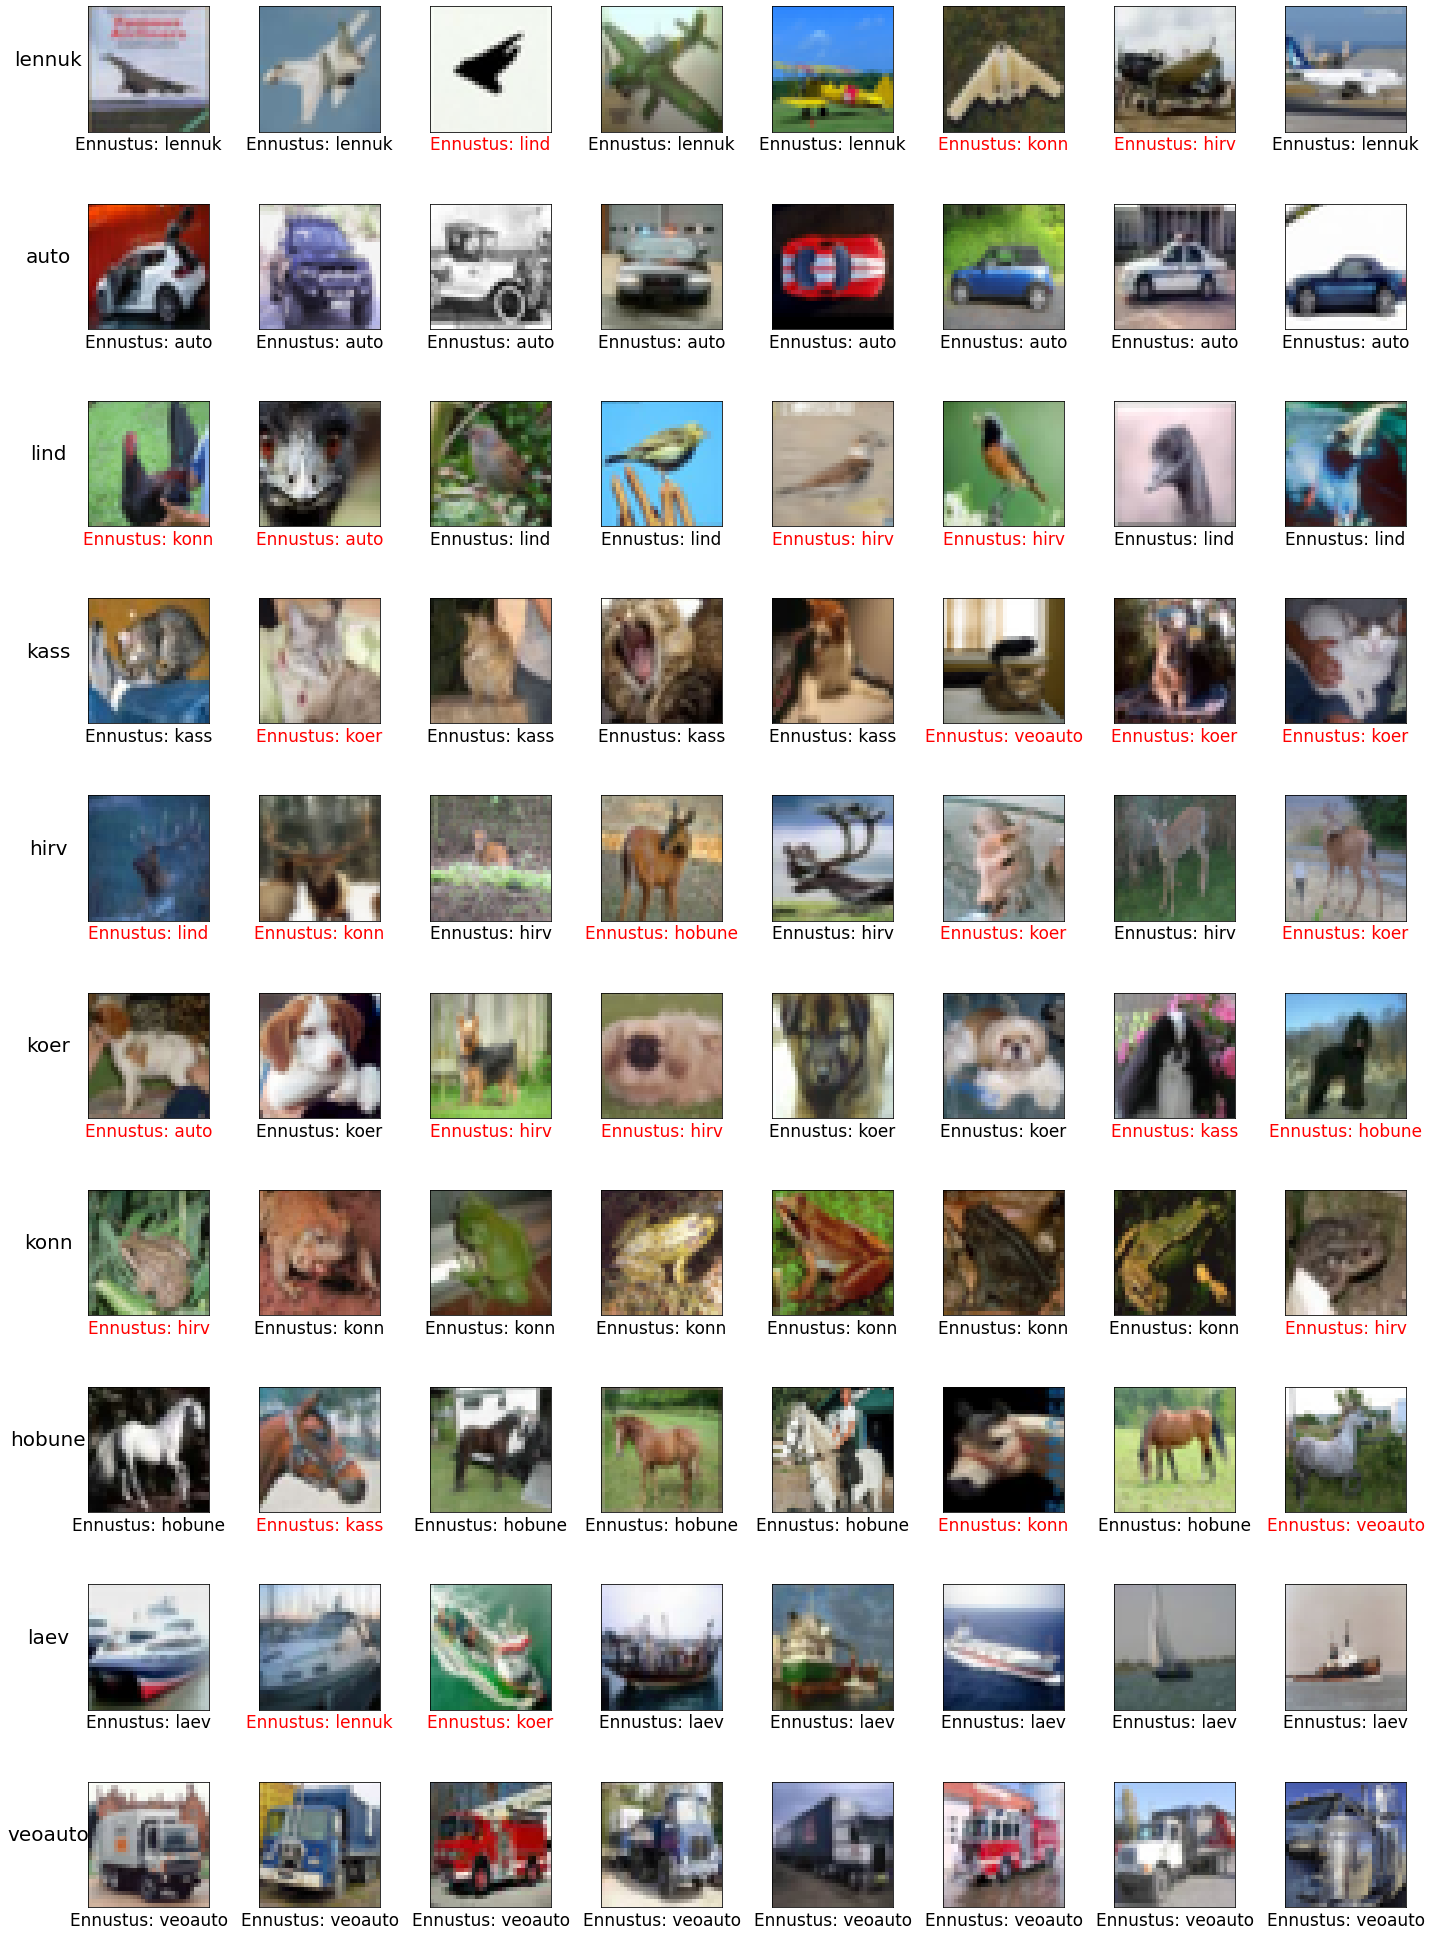

In [8]:
preds = np.argmax(model.predict(test_img), axis=1)
#print(np.bincount(preds)) ennustuste hulgas on rohkem mõnda asja

plt.figure(figsize=(20,27))
for i in range(10): # iga klassi jaoks
    this_class_idx = np.where(test_label.flatten()==i)[0]
    for j in range(8):
      plt.subplot(10,8,i*8 +j+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(test_img[this_class_idx[j]]+x_train_mean, cmap=plt.cm.binary, aspect="auto")
      label=plt.xlabel("Ennustus: " + class_names[int(preds[this_class_idx[j]])],fontsize=17)
      if not class_names[int(preds[this_class_idx[j]])] == class_names[i]:
          label.set_color("red")
      if j==0:
        plt.ylabel(class_names[i],rotation=0, fontsize=20, labelpad=40)
plt.tight_layout(h_pad=5)
plt.show()

Vaadeldes neid väljundeid võib tekkida intuitsioon, et meie mudel on mõningate klasside äratundmises parem kui teiste. Näiteks tundub, et klass "koer" tekitab suuri probleeme - mudel kipub koeri igasugusteks teisteks klassideks pidama. Samas veoautode puhul ei sattunud meie 10 näite hulka ühtegi eksimust. 

Vaatame tulemusi nüüd iga klassi jaoks eraldi, selle jaoks kasutame kahte mõõdikut- **täpsus ja saagis.**

## Definitsioonid

**SAAGIS** *ütleb, kui palju mingisse klassi kuuluvatest objektidest mudel suudab üles leida. Kui me näitame mudelile sadat pilti koertest, siis mitu korda annab mudel vastuseks "koer".*

**TÄPSUS** *ütleb meile, kui palju me saame usaldada oma mudelit, kui ta väidab, et ta leidis pildilt minigit klassi objekti. Kui mudel ütleb 100 pildi puhul, et tegu on klassiga "koer", siis mitu neist piltidest tegelikult koerad on.*


**Järgnev koodikast** arvutab täpsuse ja saagise iga klassi jaoks.

In [9]:
# importdime funktsioonid arvutamaks täpsuse ja saagise
from sklearn.metrics import confusion_matrix, precision_score, recall_score

pre = precision_score(test_label.flatten(),preds,average=None)
rec = recall_score(test_label.flatten(),preds, average=None)
for i in range(10):
  print("SAAGIS: Mudel leidis üles ", np.round(rec[i]*100,1), " protsenti klassi  "+class_names[i]+"  piltidest")

for i in range(10):
  print("TÄPSUS: Kui mudel andis vastuseks '"+class_names[i]+"' oli täpsus ",np.round(pre[i]*100,1))

SAAGIS: Mudel leidis üles  63.0  protsenti klassi  lennuk  piltidest
SAAGIS: Mudel leidis üles  68.8  protsenti klassi  auto  piltidest
SAAGIS: Mudel leidis üles  39.3  protsenti klassi  lind  piltidest
SAAGIS: Mudel leidis üles  36.8  protsenti klassi  kass  piltidest
SAAGIS: Mudel leidis üles  55.8  protsenti klassi  hirv  piltidest
SAAGIS: Mudel leidis üles  47.0  protsenti klassi  koer  piltidest
SAAGIS: Mudel leidis üles  64.2  protsenti klassi  konn  piltidest
SAAGIS: Mudel leidis üles  60.3  protsenti klassi  hobune  piltidest
SAAGIS: Mudel leidis üles  66.1  protsenti klassi  laev  piltidest
SAAGIS: Mudel leidis üles  66.5  protsenti klassi  veoauto  piltidest
TÄPSUS: Kui mudel andis vastuseks 'lennuk' oli täpsus  64.9
TÄPSUS: Kui mudel andis vastuseks 'auto' oli täpsus  66.8
TÄPSUS: Kui mudel andis vastuseks 'lind' oli täpsus  49.4
TÄPSUS: Kui mudel andis vastuseks 'kass' oli täpsus  37.9
TÄPSUS: Kui mudel andis vastuseks 'hirv' oli täpsus  46.5
TÄPSUS: Kui mudel andis vastuse

Näeme, et on peaaegu kahekordsed erinevused klasside saagiste ja täpsuste vahel. Andmeteadlasele on see oluline info, sest kui mingit mudelit päris elus rakendada, on oluline aimata, millal see eksida võiks. Lisaks võib olla kasutusvaldkond selline, kus polegi oluline näiteks konnasid täpselt tuvastada ja halvad tulemused mõne klassi jaoks pole mudeli kasutaja jaoks probleem. Antud juhul on muidugi mudel nii ebatäpne, et on raske teda üldse kasutada.

Siiski, et meie vigade analüüs oleks täielikum, visualiseerime ka täpsemalt, milliseid klasse mudel omavahel segamini ajas. Selleks kasutatakse **eksimismaatriksit**, kus read vastavad õigetele märgenditele, veerud mudeli ennustustele ja iga väärtus maatriksis ütleb, kui palju antud märgendiga punkte antud klassi ennustati. Seega kui vaatame rida "lennuk" ja veergu "laev", siis väärtus 111 ütleb, et 111 lennukipilti klassifitseeriti ekslikult laevadeks. 

**Järgnev koodikast joonistab eksimismaatriksi.**

Järgnevalt visualiseerime eksimismaatriksi, kus read vastavad piltide tegelikele klassidele ja veerud ennustustele.


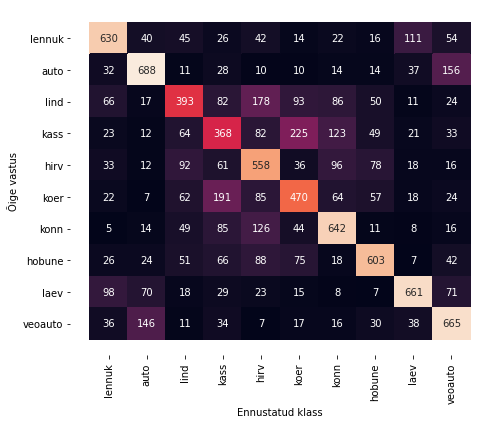

In [10]:
import seaborn as sns # teek, mis aitab joonistada ilusa värvilise maatriksi

print("Järgnevalt visualiseerime eksimismaatriksi, kus read vastavad piltide tegelikele klassidele ja veerud ennustustele.")
cm_fcnn = confusion_matrix(test_label.flatten(),preds)

plt.figure(figsize=(7,6))
ax= plt.subplot()
sns.heatmap(cm_fcnn, annot=True, ax = ax,fmt='g',cbar=False); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Ennustatud klass');ax.set_ylabel('Õige vastus'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names,rotation="vertical"); ax.yaxis.set_ticklabels(class_names,rotation="horizontal");
plt.xlim([-0.5,10.5])
plt.ylim([10.5,-0.5])
plt.tight_layout()
plt.show()

**Milliseid tähelepanekuid mudeli võimete kohta võib teha mudeli ennustuste (joonis, kus on 10 pilti igast klassist), täpsuste, saagiste ja  eksimismaatriksi põhjal?**
* Paljud mudeli poolt tehtud eksimused on sellised, mida mida inimene kunagi ei teeks.
* Kui mudel annab vastuseks "laev", siis enamasti on vastus õige
* Kui mudel annab vastuseks "hirv", siis enamasti on vastus õige
* Mudelil pole mingit probleemi eristada koeri kassidest
* Mudel ajab laevu hobustega sassi väga harva
* Andes sisendiks veoauto pildi, ennustab mudel selle alati õigesti klassi "veoauto" 

Vastused leiad siit: https://courses.cs.ut.ee/2020/Tehisintellekti_algkursus/spring/Main/PARTIIIkys0


## 2.2 Konvolutsioonilised tehisnärvivõrgud

**Konvolutsioonilised tehisnärvivõrgud** võtavad oma arvutustes arvesse pikslite naabrussuhteid. Konvolutsiooniliste kihtide filtreid rakendatakse teatud suurusega pildiosadele - seega iga filtri rakendamisega võetakse koos arvesse naaberpikslite väärtusi, mitte igat väärtust eraldi ega kõiki 32x32x3=3072 väärtust korraga. 

Teatud mõttes otsivad need võrgud mingeid detaile erinevatest pildiosadest. Alles pärast oluliste ruumiliste detailide tuvastamist rakendavad need võrgud täissidusaid kihte ja väljastavad lõpuks vastuse.

Et võrk suudab õppimise käigus ise leida need ruumilised detailid, mida tasub pildilt otsida, on tegu äärmiselt efektiivse meetodiga masinnägemises.


Juba loengust teame, et konvolutsiooilised tehisnärvivõrgud on väga head objektide tuvastamises fotodelt. See tähendab, et andes võrgule sisendiks pildi, suudab võrk aru saada, milline objekt on pildil. 

See ei tähenda siiski, et selline võrk suudaks ära tunda ükskõik millise objekti ükskõik milliselt pildilt:
- Sisendina saab kasutada kindla suurusega pilte - sama suuri, kui pildid, mille abil mudelit õpetati (32x32). Soovitav on ka, et piltide tüüp oleks sama - Näiteks kui mudel treeniti fotodel, siis joonistustel võib mudel ebatäpseid vastuseid anda.
- Mudel suudab ära tunda vaid objekte, mida ta on ära tundma treenitud. Tundmatute objektide tuvastamiseks teda kasutada ei saa.

Pildi suurust on muidugi alati võimalik muuta nii, et see vastaks soovitule. Seega põhimõtteliselt saab sisendina ikkagi kasutada ükskõik millist pilti.
Paljud päriselt kasutatavad rakendused kasutavad just ImageNeti andmestikul treenitud mudeleid, see tähendab, et nad ootavad sisendiks 224x224 suurusega pilte. Kui tahta neid mudeleid rakendada suurematele piltidele, näiteks oma telefoniga või kaameraga tehtud piltidele, tuleb pildid enne väiksemaks teha.

**Järgnev koodikast**
- Laeb alla CIFAR10 andmestikul treenitud konvolutsioonilise tehisnärvivõrgu (mudeli).
- Kuvab välja fakti, et see võrk sisaldab lausa 41 kihti! (Ehk tegu on päris sügava võrguga.)
- Loeb kokku õpitavate kaalude arvu selles võrgus ja võrdleb seda kaalude arvuga meie eelmises, täissidusas võrgus.

In [11]:
# järgnev rida laeb alla (Google'i serverisse, kus see kood jookseb, mitte teie arvutisse) ühe
# konvolutisioonilise tehisnärvivõrgu, mis on treenitud CIFAR10 pilte klassifitseerima
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cfg3-B-eg5EBPqqr6Hq47mYKD1xznf6B' -O keras_cifar10_trained_Resnet.h5 -q

#mudel on serveri kõvekettal, loeme selle mudeli Püütonisse sisse
CNN_model = keras.models.load_model("keras_cifar10_trained_Resnet.h5")
#CNN_model.summary() # see rida kuvaks mudeli kirjelduse kiht-kihi haaval, aga see on siin kuvamiseks liiga pikk

count=0
for l in CNN_model.layers:
    if len(l.get_weights())>0:
            count +=1

print("Sellel mudelil on kokku ", count ," kihti")
print("Sellel mudelil on kokku ",CNN_model.count_params()," parameetrit. Kuigi täissidus võrk oli vähem sügav, oli parameetreid ligi 5 korda rohkem: ", model.count_params())


Sellel mudelil on kokku  41  kihti
Sellel mudelil on kokku  274442  parameetrit. Kuigi täissidus võrk oli vähem sügav, oli parameetreid ligi 5 korda rohkem:  1393610


Märgime, et masinõppe mudelite puhul kehtib enamasti reegel: mida rohkem õpitavaid kaale (parameetreid), seda võimsam on mudel. See tähendab, et mudelil on suurem võimalus ülesanne lahendada, aga samas ka suurem oht ülesobituda. Sellest järelduks, et meie täissidus võrk peaks olema võimekam kui 5 korda vähemate kaaludega konvolutsiooniline võrk. Tegelikkuses on aga väga suur roll ka sellel, kas mingi mudelitüüp (tehisnärvivõrgu tüüp) sobib teatud tüüpi andmetega töötamiseks. Näeme nüüd kohe, et konvolutsiooniline võrk, vaatamata oma väiksemale arvule õpitavatele kaaludele, on nii treeningandmetel kui valideerimisandmetel väga palju täpsem, kui täissidus võrk oli.

**Järgnevas koodikastis** laseme konvolutsioonilsel võrgul ennustada klassid nii treenimisel kasutatud andmete jaoks kui ka valideermisandmete jaoks. Arvutame mudeli täpsused (kui mitu protsenti ennustustest olid õiged).


In [12]:
kadu, täpsus = CNN_model.evaluate(train_img, oh_train_label)
print("\n \n Konvolutsiooonilise mudeli täpsus treening-andmetel on: ", np.round(täpsus*100,2), " %")

kadu, täpsus = CNN_model.evaluate(test_img, oh_test_label)
print("\n \n Konvolutsiooonilise mudeli täpsus test-andmetel on: ", np.round(täpsus*100,2), " %")

1563/1563 [==============================] - 42s 10ms/step - loss: 0.1789 - accuracy: 0.9824

 
 Konvolutsiooonilise mudeli täpsus treening-andmetel on:  98.24  %
313/313 [==============================] - 3s 9ms/step - loss: 0.4294 - accuracy: 0.9177

 
 Konvolutsiooonilise mudeli täpsus test-andmetel on:  91.77  %


Selle mudeli **keskmine täpsus treeningandmestiku piltidel on 98.2 protsenti** ning **keskmine täpsus valideerimisandmestiku piltidel on 91.8 protsenti**, mis on väga palju täpsemad kui täissidus mudel.  Võime öelda, et täissidus mudel (ja otsustusmetsa mudel eelmises vihikus) olid alasobitunud, nad polnud isegi treeningandmetel head. Konvolutsiooniline võrk seevastu on hea nii treening kui valideerimisandmetel (väike ülesobitumine on siiski toimunud).

Vaatame ka **täpsust** ja **saagist** klass klassi haaval.


In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
preds = CNN_model.predict(test_img)
confidences = np.max(preds, axis=1)
predictions = np.argmax(preds, axis=1)

pre = precision_score(test_label.flatten(),predictions,average=None)
rec = recall_score(test_label.flatten(),predictions, average=None)
for i in range(10):
  print("Saagis: Mudel leidis üles ", np.round(rec[i]*100,1), " protsenti klassi  "+class_names[i]+"  piltidest")

for i in range(10):
  print("Täpsus: Kui mudel andis vastuseks '"+class_names[i]+"' oli täpsus ",np.round(pre[i]*100,1))

Saagis: Mudel leidis üles  93.5  protsenti klassi  lennuk  piltidest
Saagis: Mudel leidis üles  97.0  protsenti klassi  auto  piltidest
Saagis: Mudel leidis üles  88.9  protsenti klassi  lind  piltidest
Saagis: Mudel leidis üles  82.3  protsenti klassi  kass  piltidest
Saagis: Mudel leidis üles  93.2  protsenti klassi  hirv  piltidest
Saagis: Mudel leidis üles  85.8  protsenti klassi  koer  piltidest
Saagis: Mudel leidis üles  94.9  protsenti klassi  konn  piltidest
Saagis: Mudel leidis üles  93.8  protsenti klassi  hobune  piltidest
Saagis: Mudel leidis üles  94.4  protsenti klassi  laev  piltidest
Saagis: Mudel leidis üles  93.9  protsenti klassi  veoauto  piltidest
Täpsus: Kui mudel andis vastuseks 'lennuk' oli täpsus  90.6
Täpsus: Kui mudel andis vastuseks 'auto' oli täpsus  94.9
Täpsus: Kui mudel andis vastuseks 'lind' oli täpsus  90.8
Täpsus: Kui mudel andis vastuseks 'kass' oli täpsus  83.6
Täpsus: Kui mudel andis vastuseks 'hirv' oli täpsus  91.3
Täpsus: Kui mudel andis vastuse

Näeme, et on klasse, mille puhul meie konvolutsiooniline mudel on vähem täpne kui keskmiselt (kaldub teisi asju selleks klassiks pidama)
või vähem saagikas (kaldub seda tüüpi pilte millekski muuks klassifitseerima). 

Milliseid klasse millega sassi aetakse näeme paremini ** eksimismaatriksis.**

Järgnevalt prindime  eksimismaatriksi, kus read vastavad piltide tegelikele klassidele ja veerud ennustustele.


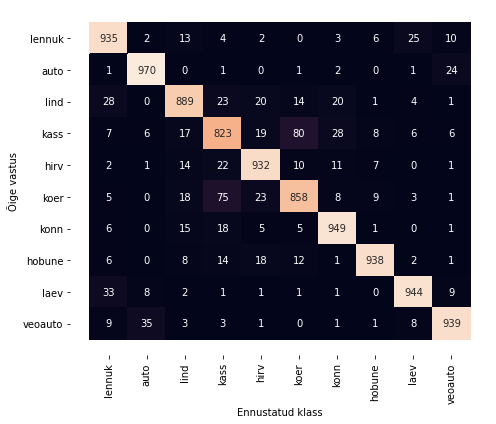

In [14]:
from sklearn.metrics import confusion_matrix
print("Järgnevalt prindime  eksimismaatriksi, kus read vastavad piltide tegelikele klassidele ja veerud ennustustele.")
cm = confusion_matrix(test_label.flatten(), predictions)

import seaborn as sns

fig = plt.figure(figsize=[7,6])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g',cbar=False); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Ennustatud klass');ax.set_ylabel('Õige vastus'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_names,rotation="vertical"); ax.yaxis.set_ticklabels(class_names,rotation="horizontal");
plt.xlim([-0.5,10.5])
plt.ylim([10.5,-0.5])
plt.tight_layout()
plt.show()


Sellelt jooniselt näeme, milliseid klasse meie üldiselt päris hea mudel segamini ajas. Näiteks 1000st pildist, millel oli kass, ennustas mudel 80 puhul vastuseks hoopis "koer". Koeri kassideks pakkus mudel 75 korral tuhandest. Mõndasid teisi klasse mudel meie 10000 valideerimisnäite (1000 igast klassist) puhul kunagi segamini ei ajanud. Selline analüüs võimaldab meil mõista, millised näited on meie mudeli jaoks probleemsed. See aitab muuhulgas disainida paremaid mudeleid, mis just neil keerulistel näidetel hakkama saaks.



Et paremini tajuda, kui hea see võrk tegelikult on, vaatame ka, **milliseid vigu võrk teeb.**  Siinkohal saame mõelda, kas ka meie eksiksime neil näidetel ja kas mudeli võimekus on inimvõimekusega sarnane.


92 protsendil juhtudest mudel ei eksi, seega **oleme siin välja valinud just need juhud, kus mudel eksis.**

Siinkohal toome eraldi välja ka mudeli **enesekindluse**, ehk mis tõenäosuse mudel oma ennustusele andis. Kõikidele 10 klassile antud tõenäosused peavad kokku andma 100%. Seega kui mudel on 99% kindel, et pildil on lind, siis ühegi teise klassi tõenäosus ei saa olla suurem kui 1%. Ja kui mudel eksib, olles väga kindel, et pildil on lind, kuigi tegelikult on pildil midagi muud, siis on see probleem, sest mudel on halb oma nõrkuste äratundmises. 

Kujutagem ette, et isesõitev auto otsustab mitte pidurdada, sest nägemismudel väidab 99% kindlusega, et teel on lind (kes ei kujuta suurt ohtu ja lendab tõenäoliselt minema). Aga tegelikult on on teel hirv. Kui mudel olnuks oma "lind" ennustuses vähem kindel, võinuks autot juhtiv programm arvesse võtta, et "nägemismudel pole kindel" ja ikkagi igaks juhuks hoogu maha võtta. Aga kui nägemismudel on oma valedes vastustes väga kindel, on ülejäänud isejuhtiva auto programmiosadel raske tuvastada, millal riske maandada ja ettevaatlikult käituda.

Oma valedele vastustele kõrge tõenäosuse andmine, ehk mitte-äratundmisest mitte arusaamine on osa **liigse enesekindluse probleemist**. See on tehisnärvivõrkude ja ka mõnede teiste klassifitseerimiseks kasutatavate mudelite puhul suur probleem.

**Järgmine koodikast** joonistab välja mõned näited valedest ennustustest ja sellest, kui suure tõenäosuse mudel oma valele ennustusele andis.

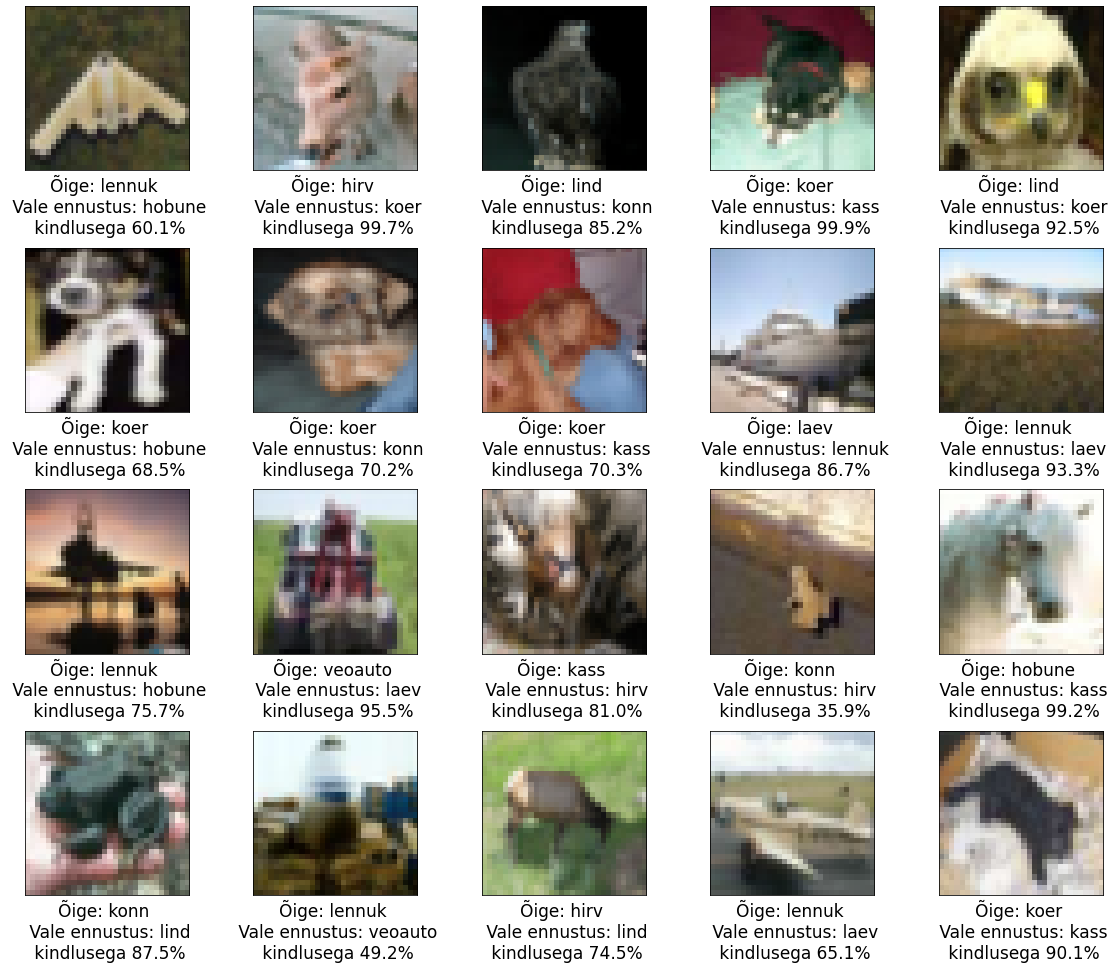

In [15]:
errors_idx = np.where(predictions != test_label.flatten())[0]

plt.figure(figsize=(16,16))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_img[errors_idx[i]] + x_train_mean, cmap=plt.cm.binary)
    plt.xlabel("Õige: "+class_names[int(test_label[errors_idx[i]])]+" \n Vale ennustus: " + class_names[int(predictions[errors_idx[i]])] + "\n kindlusega "+str(np.round(confidences[errors_idx[i]]*100,1))+"%",fontsize=17)
plt.tight_layout()
plt.show()

Nagu näeme, on nende 8% vigade hulgas, mille mudel valideerimisandmetel tegi, ka inimese jaoks üsna ilmselgeid pilte. Näiteks vaevalt, et keegi lugejatest pakuks esimese ja teise rea esimeste piltide vastuseks "hobune".

### Kontrollküsimusi selle alapeatüki kohta:
(sarnaseid küsimusi võib tulla ka Moodle'i testis)

Milline väide on õige:

* See mudel ennustab täpsemini kui eelmine
* Ei ole ühtegi klassi, mille puhul see mudel ennustaks halvemini kui eelmine
* See mudel teeb lihtsalt teistsuguseid vigu kui eelmine, aga on sarnase täpsusega
* Klassid kass ja koer on selle mudeli jaoks keerulisemad eristada kui näiteks veoauto ja lennuk
* See mudel ei ennusta valideerimisandmetel kordagi, et tegelikult kassi sisaldav pilt kuulub klassi koer.
* See mudel ei ennusta valideerimisandmetel kordagi, et tegelikult lindu sisaldav pilt kuulub klassi auto.

Vastused leiad siit: https://courses.cs.ut.ee/2020/Tehisintellekti_algkursus/spring/Main/PARTIIIkys1


# 3. Veel näiteid liigse enesekindluse probleemist

Oleme alla laadinud ka CIFAR100 andmestiku, mis sisaldab seni kasutatud CIFAR10st erinevat tüüpi objekte.

Mis oleks mõistlik vastus küsimusele "Kas pildil on lennuk, auto, lind, kass, hirv, koer, konn, hobune, laev või veoauto?", kui pildil on tegelikult hoopis õunad või päevalill? Õiget vastus sellele küsimusele pole, sest küsimus on justkui valesti esitatud. 

Seega, millist väljundit me ootame, kui anname oma mudelile (mis on treenitud CIFAR10 kümmet klassi eristada) sisendiks hoopis pildi õunast? Üldiselt oodatakse mudelilt sellisel juhul ühtlast tõenäosusjaotust 10 võimaliku klassi vahel - kuna pildil pole ükski küsitavatest objektidest, siis ei tohiks mudel ühelegi klassile väga suurt tõenäosust anda. Seega peaks mudel andma kõigile kümnele klassile tõenäosuse 10% (ehk: kõik on samavõrra valed). Kui seda on keeruline saavutada, siis igal juhul oleks väga soovitav, et mudel ei annaks ühelegi variandile üle 50% kindlust.

Praktikas näeme aga, et võrgud on liiga enesekindlad. Nad annavad tundmatute piltide puhul väga kindlaid vastuseid. Neil puudub võime aru saada, et nad ei tea.

**Järgmises koodikastis** tõlgime ära mõned CIFAR100 klassinimed, mida kasutama hakkame. Midagi olulist selles kastis ei toimu, seda pole vaja lugeda.

In [16]:
# EI OLE OLULINE VAADATA
#klasside nimed CIFAR100 andmestikus
CIFAR100_LABELS_LIST = [
    'õun', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'liblikas', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'pilv', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'pilvelõhkuja', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'päevalill', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]
c100_labels_dict={}
for i in range(len(CIFAR100_LABELS_LIST)):
  c100_labels_dict[CIFAR100_LABELS_LIST[i]]=i


Vaatame nüüd meie CIFAR10-l treenitud ja 92% valideerimis-täpsusega mudeli vastuseid, kui anname sisendiks pilte objektidest, mida see mudel ei tunne. Täpsemalt, anname sisendiks pilte õunadest, pilvelõhkujatest, liblikatest, päevalilledest ja pilvedest.

Mudelil pole võimalik õigesti vastata, aga oleks võimalik vastata "vähem valesti" ehk vähema kindlusega valesti.

**Järgnevas kastis** anname meie konvolutsioonilisele mudelile sisendiks mõned "võõrast klassist" pildid. Joonistame need pildid välja ja kuvame meie mudeli ennustuse (mis on paratamatult vale) ning selle, kui kindel mudel oma ennustuses oli.


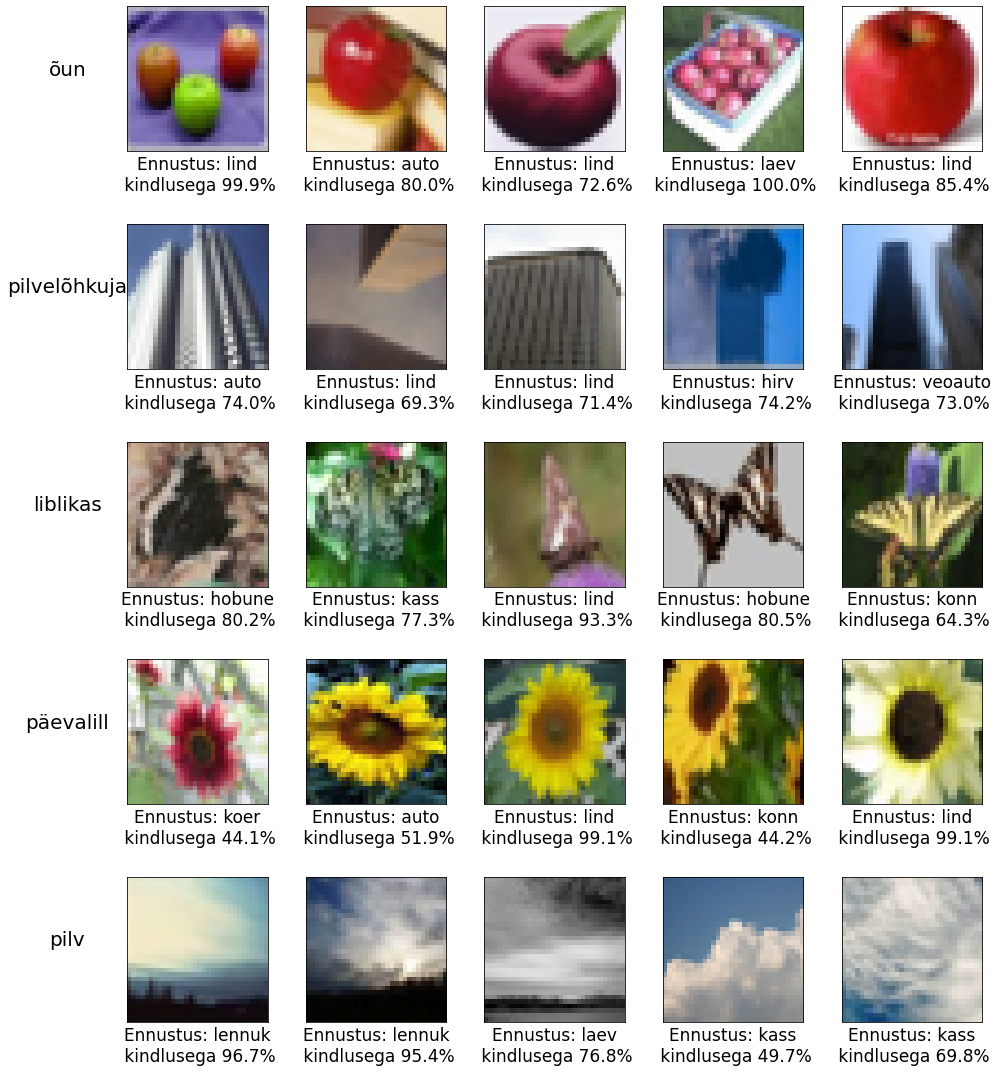

In [17]:
plt.figure(figsize=(14,15))
for i,klass in enumerate(["õun", "pilvelõhkuja", "liblikas","päevalill","pilv"]): 
    this_class_idx = np.where(c100_test_labels.flatten()==c100_labels_dict[klass])[0]
    output = CNN_model.predict(c100_test_img[this_class_idx[:5]])
    kindlus = np.max(output,axis=1)
    ennustused = np.argmax(output,axis=1)

    for j in range(5):
      plt.subplot(5,5,i*5 +j+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(c100_test_img[this_class_idx[j]]+x_train_mean, cmap=plt.cm.binary, aspect="auto")
      label=plt.xlabel("Ennustus: "+class_names[ennustused[j]] +"\n kindlusega "+str(np.round(kindlus[j]*100,1))+"%",fontsize=17)
      if j==0:
        plt.ylabel(klass,rotation=0, fontsize=20, labelpad=60)
plt.tight_layout(h_pad=3)
plt.show()


Mitmetel puhkudel on mudel oma ennustustes üsnagi kindel. Aga see on ka mõneti mõistetav - kui pildil on taevas, on arusaadav, miks võiks vastuseks pakkuda lennuk.

Seega teeme asja veelgi selgemaks - anname mudelile sisendiks pildid, mis ei kujuta üldse mitte midagi. 

1)Anname sisendiks ühtlaselt halli pildi  
2)Täidame pildi piksliväärtused suvaliste arvudega
 

Sel juhul ei tohiks pildil olla mingeid kaudseid viiteid, mis paneksid tehisnärvivõrgu mingit klassi eelistama.

**Järgnevas kastis** loome halli pildi ning mõned suvaliste piksliväärtustega pildid. Laseme mudelil nende piltide puhul ennustada, mis klassiga on tegu ning visualiseerime pildid, ennustused ja mudeli enesekindluse.


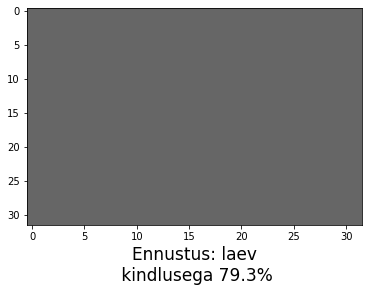


 
 Genereerime pildid, mis on täidetud suvaliste arvudega ja vaatame, mida mudel nende kohta arvab:


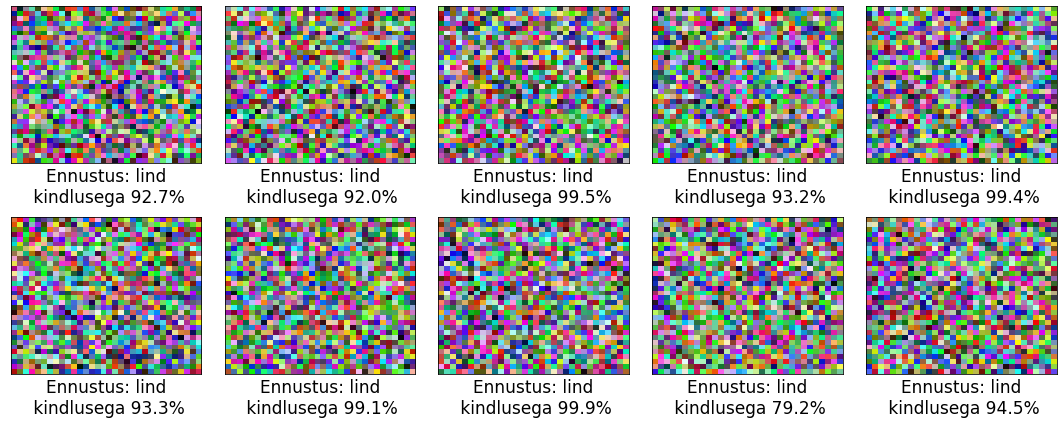


 Keskmine kindlus valge müra piltidel:  0.9428409


In [18]:
# ühtlaselt hall pilt
gray_images = np.ones((2,32,32,3))*0.4

plt.imshow(gray_images[0],cmap=plt.cm.binary, aspect="auto")
gray_output = CNN_model.predict(gray_images-x_train_mean)
ennustused = np.argmax(gray_output,axis=1)
kindlus = np.max(gray_output,axis=1)
label=plt.xlabel("Ennustus: "+class_names[ennustused[0]] +"\n kindlusega "+str(np.round(kindlus[0]*100,1))+"%",fontsize=17)
plt.show()

print("\n \n Genereerime pildid, mis on täidetud suvaliste arvudega ja vaatame, mida mudel nende kohta arvab:")

#juhuslikud pildid (müra)
random_images = np.random.random((10,32,32,3))
random_images_norm = random_images - x_train_mean


random_output = CNN_model.predict(random_images_norm)
ennustused = np.argmax(random_output,axis=1)

kindlus = np.max(random_output,axis=1)

plt.figure(figsize=(15,6))

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(random_images[i],cmap=plt.cm.binary, aspect="auto")
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  label=plt.xlabel("Ennustus: "+class_names[ennustused[i]] +"\n kindlusega "+str(np.round(kindlus[i]*100,1))+"%",fontsize=17)

plt.tight_layout()
plt.show()
print("\n Keskmine kindlus valge müra piltidel: ", np.mean(kindlus))


## Liigse enesekindluse kokkuvõte

Mudel on andmetel, millesuguseid ta pole kunagi näinud, liiga enesekindel. Ehk teaduskeeles: mudel on liiga enesekindel sisenditel, mis on väljaspool tema treeningjaotust (ingl. overconfident out of distribution).

Selline liigne enesekindlus võimaldab ka luua **vastunäiteid** (ingl.k. adversarial examples), mis näevad inimsilmale välja nagu teatud klassi objektid, aga võrk on täiesti veendunud, et tegu on hoopis teise klassi objektiga. Seliseid valesid vastuseid nägime ülal ka juhuslikult juhtumas, aga on võimalik neid ka tahtlikult luua. Näiteks saab pildile veoautost lisada just täpselt sellist müra (ehk väikeseid muudatusi väärtustes), mis paneb võrku uskuma, et tegu on linnu või loomaga. 

Kui võrgu petmine nägema veoauto asemel looma pole põnev, siis mõtelgem väljaspool CIFAR10 klasse. Näiteks näotuvastus: teatud tingimustel on võimalik võrku panna uskuma, et pildil on keegi teine, lisades pildile veidi väga spetsiifiliselt disainitud müra. See müra võib olla nii märkamatu, et inimene isegi ei saa aru, et pilti on töödeldud. Nagu ikka, võib näiteid tuua ka isejuhtivate autode valdkonnast: kui autod kasutavad liiklusmärkide tuvastamiseks tehisnärvivõrke, siis on potentiaalselt oht, et keegi prindib ja kleebib liiklusmärkidele midagi, mis paneb teatud võrgu täie kindlusega uskuma, et stoppmärgi asemel on peatee märk.  

Sellisel viisil on loodud isegi füüsilisi 3D-prinditud objekte, mida teatud võrk absoluutselt iga nurga ja kauguse alt millekski muuks peab. Selline füüsiline objekt näitlikustab, et valesti klassifitseerimine ei juhtu ainult mingite valgusolude ja vaatenurga (eba)õnnelikul kokkusattumusel, vaid on antud võrgu süsteemne puudujääk.

Tehisnärvivõrkude ja masinnägemise teadlaskond on selle probleemi tõsiselt käsile võtnud ja on loodud mitmeid potentsiaalseid meetodeid, mis aitavad mudelit usaldusväärsemaks ja raskemini petetavaks teha. Usutavasti, on tegu probleemiga, mille suurte firmade insenerid on juba ära lahendanud (aga pole avalikustanud). Siinkohal mainisime seda probleemi pigem selleks, et uued tehisvõrkude kasutajad ja kasutuselevõtjad sellest teadlikud oleks ning oma firmat ja kliente ohtu ei seaks.


## BOONUS:  mudeli üldistusvõime teist tüüpi piltidel

Mainisime selle vihiku alguses, et mudeli ootab sisendiks sama tüüpi pilte kui need, millel ta treeniti. Siinkohal ei pea me silmas, mitte pildil oleva objekti tüüpi, vaid pildi stiili - on tegu foto, joonistuse või millegi muuga.

Järgev koodikast laeb alla kaks erinevas stiilis joonistust koeradest, skaleerib need suurusele 32x32 pikslit ja rakendab neile meie konvolutsioonilist mudelit. Kummalgi juhul ei suuda mudel pildilt koera tuvastada, vaid annab vastuseks midagi muud.

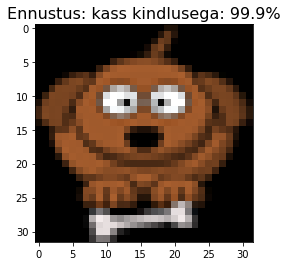

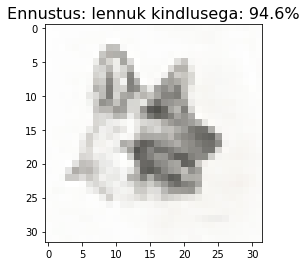

In [19]:
! wget --no-check-certificate http://res.publicdomainfiles.com/pdf_view/74/13932777616378.png -O cartoon_dog.png -q
! wget --no-check-certificate https://cdn.pixabay.com/photo/2016/06/21/01/07/drawing-1470278_960_720.jpg -O cartoon_dog2.jpg -q

from PIL import Image

img = Image.open('cartoon_dog.png')
img2 = Image.open('cartoon_dog2.jpg')

img = img.resize((32, 32))  # resizes image in-place
img = img.convert('RGB')

img2 = img2.resize((32, 32))  # resizes image in-place
img2 = img2.convert('RGB')


#töötleme samal viisil nagu oma andmestiku pilte
np_img = np.array(img, dtype="float") /255 -x_train_mean
np_img2 = np.array(img2, dtype="float") /255 -x_train_mean

tõenäosused = CNN_model.predict(np.stack([np_img,np_img2], axis=0))
pp=np.argmax(tõenäosused,axis=1)
kindlus = np.max(tõenäosused, axis=1) 

imgplot = plt.imshow(img)
plt.title("Ennustus: "+str(class_names[pp[0]])+ " kindlusega: "+str(np.round(kindlus[0]*100,1))+"%",fontsize=16)
plt.show()
imgplot2 = plt.imshow(img2)
plt.title("Ennustus: "+str(class_names[pp[1]])+ " kindlusega: "+str(np.round(kindlus[1]*100,1))+"%",fontsize=16)
plt.show()


Lisaks võime vaadata ka, mis juhtub, kui valideerimisandmed (millel mudeli  täpsus oli 92%) mustvalgeteks teha. Mudel on treenides näinud pigem värvilisi pilte (andmesik sialdab võibolla ka mõnd mustvalget pilti). Kas selline "stiilimuutus" mõjutab mudeli täpsust?

In [20]:
taastatud = test_img + x_train_mean
mustvalge = 0.213*taastatud[:,:,:,0] + 0.715*taastatud[:,:,:,1]+ 0.007*taastatud[:,:,:,2] # -> 84.86

mustvalge = np.stack([mustvalge,mustvalge,mustvalge],axis=3)
kadu, täpsus = CNN_model.evaluate(mustvalge-x_train_mean, oh_test_label)
print("\n \n Konvolutsiooonilise mudeli täpsus mustvalgetel test-andmetel on: ", np.round(täpsus*100,2), " %")

#kadu, täpsus = model.evaluate(mustvalge-x_train_mean, oh_test_label)
#print("\n \n Täissiduse mudeli täpsus mustvalgetel test-andmetel on: ", np.round(täpsus*100,2), " %")

313/313 [==============================] - 3s 10ms/step - loss: 0.7086 - accuracy: 0.8486

 
 Konvolutsiooonilise mudeli täpsus mustvalgetel test-andmetel on:  84.86  %


Näeme, et mustvalgeks tehtud piltidel on täpsus märgatavalt väiksem - 87 protsenti 92% asemel. Mida erinevamaks me pildid treenimisel tehtud piltidest teeme, seda rohkem täpsus väheneb.

Sellega lõpetamegi käesoleva praktilise näite. Loodame, et tajute nüüd paremini, et konvolutsioonilised võrgud on küll väga võimekad masinnägemise mudelid, aga alati on ka AGAsid. 
